### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import scipy.stats as st
import warnings
import seaborn as sns
from scipy.stats import mannwhitneyu
import math as mth

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [3]:
def total_info(data):
    print('Ознакомление с датафреймом')
    print('')
    
    
    display(data.head())
    print('Получены первые 5 строк датафрейма')
    print('')
    
    size = 'Общее количество столбцов в датафрейме: {cols} Количество строк в датафрейме {rows}'
    size = size.format(cols = data.shape[1], rows = data.shape[0])
    print(size)
    print('')
    
    print(data.info())
    print('Получена основная информация о датафрейме')
    print('')
    
    print('Количество пропущенных в каждом столбце:')
    print(data.isna().sum())
    print('')
    
    duplicated = 'Количество полностью дублирующихся строк: {duplicate}. В процентах {percent}%'
    duplicated = duplicated.format(duplicate =data.duplicated().sum(), percent = round(data.duplicated().sum() / data.shape[0] * 100,3))
    print(duplicated)

total_info(df)

Ознакомление с датафреймом



,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Получены первые 5 строк датафрейма

Общее количество столбцов в датафрейме: 4 Количество строк в датафрейме 244126

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
Получена основная информация о датафрейме

Количество пропущенных в каждом столбце:
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Количество полностью дублирующихся строк: 413. В процентах 0.169%


**После ознакомления с датафреймом выявлено:**
    
- Названия столбцов не соответствуют змеиному регистру, на этапе предобработки необходимо привести их в соответствие с PEP8
- Размер датафрейма 244126 строк и 4 столбца
- В столбце EventTimestamp несоответсвие типу данных (представляет собой количество секунд с начала эпохи Unix (1 января 1970 года 00:00:00 UTC))
- Обнаружено 413 полностью дублирующмхся строк, что составляет 0.169% от полного объема данных)
- Пропущенных значений нету ни в одном из столбцов

### Подготовьте данные

#### Замените названия столбцов на удобные для вас;

In [4]:
df.columns = ['event_name','user_id','event_time','group'] # user_id заменил DeviceIDHash, ExpId - на group
df.columns

Index(['event_name', 'user_id', 'event_time', 'group'], dtype='object')

Названия столбцов переведены в змеиный регистр

#### Проверьте пропуски и типы данных. Откорректируйте, если нужно;

In [5]:
df = df.drop_duplicates().reset_index(drop=True)

In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

event_name    0
user_id       0
event_time    0
group         0
dtype: int64

- Удалены 413 дублирующиеся строки
- Пропущенных значений на этапе ознакомления выявлено не было 

#### Добавьте столбец даты и времени, а также отдельный столбец дат;

In [8]:
df['event_time'] = pd.to_datetime(df['event_time'], unit = 's')
df['date'] = df['event_time'].dt.date
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [9]:
display(df.head())

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


- Столбец event_time приведен к типу datetime
- Добавлен столбец с датой date в формате date

**Выполнена предобработка данных**

- Добавлены столбец с датой, event_time переведен в формат дата и время
- Удалены пропуски
- Явных дубликатов не обнаружено
- Столбцы приведены к змеиному регистру


### Изучите и проверьте данные

#### Сколько всего событий в логе?

In [11]:
df.shape[0]

243713

Общее количетсво событий 243713

In [12]:
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

 <a id="my_anchor"></a> <a id="my_anchor2"></a>

- MainScreenAppear - появление главного экрана 119101
- OffersScreenAppear - появление экрана предложений 46808
- CartScreenAppear - экран корзины 42668
- PaymentScreenSuccessful - экран успешной оплаты 34118
- Tutorial - руководство 1018 


#### Сколько всего пользователей в логе?

In [13]:
df['user_id'].nunique()

7551

Количество уникальных пользователей 7551

#### Сколько в среднем событий приходится на пользователя?

In [14]:
df.groupby('user_id').agg({'event_name':'count'}).describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


- Медианное значение: 20
- Среднее значение: 32

#### Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого  — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [15]:
print(df['event_time'].min())
print(df['event_time'].max())
print(df['event_time'].max() - df['event_time'].min())

2019-07-25 04:43:36
2019-08-07 21:15:17
13 days 16:31:41


**Начало периода:** 2019-07-25 04:43:36
            
**Конец периода:** 2019-08-07 21:15:17
            
**Продолжительность периода:** 13 days 16:31:41

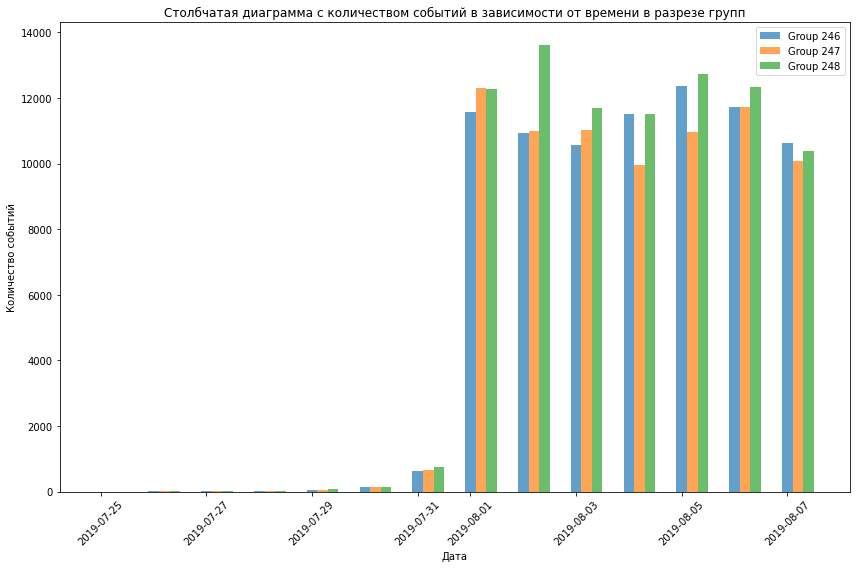

In [16]:
group_246 = df[df['group'] == 246]
group_247 = df[df['group'] == 247]
group_248 = df[df['group'] == 248]

events_246 = group_246['date'].value_counts().sort_index()
events_247 = group_247['date'].value_counts().sort_index()
events_248 = group_248['date'].value_counts().sort_index()

plt.figure(figsize=(12, 8))
plt.bar(events_246.index, events_246.values, width=0.2, align='center', label='Group 246',alpha=0.7)
plt.bar(events_247.index + pd.Timedelta(days=0.2), events_247.values, width=0.2, align='center', label='Group 247',alpha=0.7)
plt.bar(events_248.index + pd.Timedelta(days=0.4), events_248.values, width=0.2, align='center', label='Group 248',alpha=0.7)

plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Столбчатая диаграмма с количеством событий в зависимости от времени в разрезе групп')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
df_modified = df.query('date >= "2019-08-01"') # данные до 1 августа некорректны по причине их неполноты 
df.shape[0] - df_modified.shape[0]

2826

#### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [18]:
loss_percent_events = round((df.shape[0] - df_modified.shape[0]) / (df.shape[0]) * 100,2)
loss_amount_events = df.shape[0] - df_modified.shape[0]

In [19]:
loss_percent_users = round((df['user_id'].nunique() - df_modified['user_id'].nunique()) / df['user_id'].nunique() * 100,2)
loss_amount_users = df['user_id'].nunique() - df_modified['user_id'].nunique()

In [20]:
loss_events = 'Количество потерянных событий: {loss_amount_events},в процентах это составляет: {loss_percent_events}%'
loss_events = loss_events.format(loss_amount_events = loss_amount_events,loss_percent_events=loss_percent_events)
loss_users = 'Количество потерянных пользователей: {loss_amount_users},в процентах это составляет: {loss_percent_users}%'
loss_users = loss_users.format(loss_amount_users=loss_amount_users,loss_percent_users=loss_percent_users)
print(loss_events)
print(loss_users)

Количество потерянных событий: 2826,в процентах это составляет: 1.16%
Количество потерянных пользователей: 17,в процентах это составляет: 0.23%


#### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [21]:
df_modified['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

Количетство событий в каждой группе

In [22]:
df_modified.groupby('group', as_index = False).agg({'user_id':'nunique'})

,group,user_id
0,246,2484
1,247,2513
2,248,2537


В датасете присутствуют пользователи всех 3-х экспериментальных групп

### Изучите воронку событий

#### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [23]:
df_modified['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Описание каждого события было оформлено <a href="#my_anchor">ранее</a>


#### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [24]:
user_amount = df_modified.pivot_table(index = ['event_name'],
                                      values = 'user_id',
                                      aggfunc = {'nunique','count'}) \
                        .reset_index() \
                        .sort_values(by = 'nunique',ascending = False) \
                        .rename(columns = {'count':'event_count','nunique':'unique_user_amount'})
user_amount

,event_name,event_count,unique_user_amount
1,MainScreenAppear,117328,7419
2,OffersScreenAppear,46333,4593
0,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


In [25]:
user_amount['percent_from_all_unique_users'] = user_amount['unique_user_amount'].apply(lambda x: int(x / df['user_id'].nunique() * 100))
#user_amount.loc[1,'unique_user_amount']
user_amount

,event_name,event_count,unique_user_amount,percent_from_all_unique_users
1,MainScreenAppear,117328,7419,98
2,OffersScreenAppear,46333,4593,60
0,CartScreenAppear,42303,3734,49
3,PaymentScreenSuccessful,33918,3539,46
4,Tutorial,1005,840,11


- MainScreenAppear посещаяет 98% юзеров
- OffersScreenAppear 60%
- CartScreenAppear 49%
- PaymentScreenSuccessful 46%
- Tutorial 11%

#### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

События должны быть расположены в такой последовательности
1. MainScreenAppear - появление главного экрана
2. Tutorial - руководство
3. OffersScreenAppear - появление экрана предложений
4. CartScreenAppear - экран заполнения реквизитор карты 
5. PaymentScreenSuccessful - экран успешной оплаты

- Судя по тому, что Tutorial фигурирует в событиях всего около <a href="#my_anchor2">1018 раз</a>,а пропускается в 89% случаев, можно предположить, что этот этап не обязателен




In [26]:
main_events = user_amount.query('event_name != "Tutorial"')
main_events

,event_name,event_count,unique_user_amount,percent_from_all_unique_users
1,MainScreenAppear,117328,7419,98
2,OffersScreenAppear,46333,4593,60
0,CartScreenAppear,42303,3734,49
3,PaymentScreenSuccessful,33918,3539,46


- Получен датафрейм без события Tutorial

#### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [27]:
main_events.event_name.tolist()

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful']

In [28]:
main_events['unique_user_amount'].tolist()

[7419, 4593, 3734, 3539]

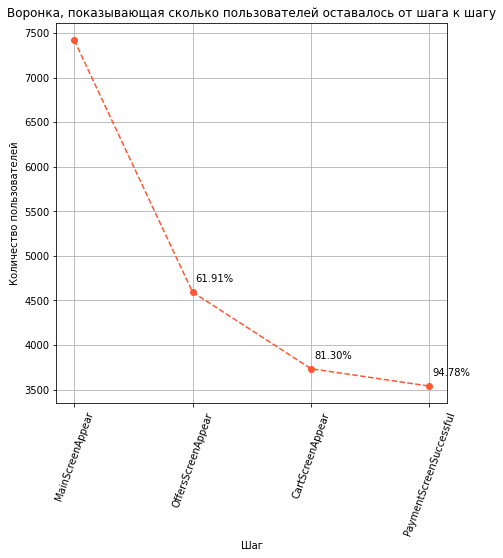

In [29]:
steps = main_events.event_name.tolist()
users = main_events['unique_user_amount'].tolist()
plt.figure(figsize=(7, 7))
plt.plot(steps, users, marker='o', linestyle='--',color='#FF5733')
plt.xticks(rotation=70)
plt.title('Воронка, показывающая сколько пользователей оставалось от шага к шагу')
plt.xlabel('Шаг')
plt.ylabel('Количество пользователей')
plt.grid(True)

for i in range(len(users) - 1):
    conversion_rate = users[i+1] / users[i] * 100
    plt.annotate(f'{conversion_rate:.2f}%', (steps[i+1], users[i+1]), textcoords="offset points", xytext=(22,10), ha='center')

plt.show()

- 1 Шаг - 100% пользователей
- До 2 из 100% дошли 62%
- На шаге 3 из них осталось 81%
- и почти все (94%) дошли до последнего шага (экрана успешной оплаты)

#### На каком шаге теряете больше всего пользователей?

- От первого до второго шага теряется 38% юзеров 
- От второго к третьему - 19%
- От третьего к последнему - 14%

#### Какая доля пользователей доходит от первого события до оплаты?

In [30]:
final_payment = '{}% пользователей проходят от главного экрана до экрана об успешной оплате'
final_payment = final_payment.format(round(main_events.loc[3,'unique_user_amount'] / main_events.loc[1,'unique_user_amount'] * 100,2))

In [31]:
print(final_payment)

47.7% пользователей проходят от главного экрана до экрана об успешной оплате


### Изучите результаты эксперимента

#### Сколько пользователей в каждой экспериментальной группе?

In [32]:
df_modified.groupby('group', as_index = False).agg({'user_id':'nunique'}).rename(columns={'user_id':'user_amount'})

,group,user_amount
0,246,2484
1,247,2513
2,248,2537


246 и 247 — контрольные группы, а 248 — экспериментальная.

#### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

In [33]:
df_no_tutorial = df_modified.query('event_name != "Tutorial"')
group_246 = df_no_tutorial[df_no_tutorial['group'] == 246].groupby('user_id', as_index=False).agg({'date': 'count'})['date']
group_247 = df_no_tutorial[df_no_tutorial['group'] == 247].groupby('user_id', as_index=False).agg({'date': 'count'})['date']
group_248 = df_no_tutorial[df_no_tutorial['group'] == 248].groupby('user_id', as_index=False).agg({'date': 'count'})['date']

Разделяем датафрейм на 3 группы

In [34]:
print(group_246.shape[0]) # Количество участников в 246 группе
print(group_247.shape[0]) # Количество участников в 247 группе
print(group_248.shape[0]) # Количество участников в 248 группе

2483
2512
2535


In [35]:
double_group_users = np.intersect1d(df_modified[df_modified['group'] == 246]['user_id'].unique(), \
                                    df_modified[df_modified['group'] == 247]['user_id'].unique())
print('Количество пользователей вошедших группу и 246, и 247 -', len(double_group_users))

Количество пользователей вошедших группу и 246, и 247 - 0


In [36]:
double_group_users = np.intersect1d(df_modified[df_modified['group'] == 246]['user_id'].unique(), \
                                    df_modified[df_modified['group'] == 248]['user_id'].unique())
print('Количество пользователей вошедших группу и 246, и 248 -', len(double_group_users))

Количество пользователей вошедших группу и 246, и 248 - 0


In [37]:
double_group_users = np.intersect1d(df_modified[df_modified['group'] == 247]['user_id'].unique(), \
                                    df_modified[df_modified['group'] == 248]['user_id'].unique())
print('Количество пользователей вошедших в группу и 247, и 248 -', len(double_group_users))

Количество пользователей вошедших в группу и 247, и 248 - 0


Пользователи, которые одновременно попали в несколько разных групп отсутствуют.

In [38]:
diff = 'Группа 246 и 247 различаются по количеству участников на {:.2f}%'
diff = diff.format((group_247.shape[0] / group_246.shape[0] * 100)- 100)
print(diff)

Группа 246 и 247 различаются по количеству участников на 1.17%


In [39]:
diff = 'Группа 246 и 248 различаются по количеству участников на {:.2f}%'
diff = diff.format((group_247.shape[0] / group_248.shape[0] * 100)- 100)
print(diff)

Группа 246 и 248 различаются по количеству участников на -0.91%


In [40]:
diff = 'Группа 246 и 248 различаются по количеству участников на {:.2f}%'
diff = diff.format((group_246.shape[0] / group_248.shape[0] * 100)- 100)
print(diff)

Группа 246 и 248 различаются по количеству участников на -2.05%


Разбиение на группы по количеству пользователей - корректно

In [41]:
#проводим тест Манна-Уитни и получаем p-значение на выходе
stat, p = st.mannwhitneyu(group_246, group_247)

#задаем критический уровень статистической значимости 
alpha = 0.05

print('p-уровень значимости = {:.2f}'.format(p))

if p < alpha:
    print('Отвергаем нулевую гипотезу, группы имееют статистически значимые различия ')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий нет')

p-уровень значимости = 0.84
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий нет


- после использования критерия Манна-Уитни p-value 0.84 (статистически значимых различий нет, не получилось отвергнуть нулевую гипотезу)
- группа 246 и 247 статистически не различаются
- А/A тест говорит о возможности использования данных групп для проведения дальнейшего эксперимента
- А так же размер выборок в ранных группах имеет незначительные различия (1.17%)

In [42]:
#проводим тест Манна-Уитни и получаем p-значение на выходе
stat, p = st.mannwhitneyu(group_246, group_248)

#задаем критический уровень статистической значимости 
alpha = 0.05

print('p-уровень значимости = {:.2f}'.format(p))

if p < alpha:
    print('Отвергаем нулевую гипотезу, группы имееют статистически значимые различия ')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий нет')

p-уровень значимости = 0.42
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий нет


Группы 246 и 248 так же, статистически не различаются

#### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [43]:
events_users = df_no_tutorial.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique'
                ).sort_values(by=246, ascending=False).rename(columns = {246:'group_246',247:'group_247',248:'group_248'}) #.reset_index()
events_users['sum_246_247'] = events_users[['group_246','group_247']].sum(axis=1)
display(events_users)


group,group_246,group_247,group_248,sum_246_247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


- Датафрейм содержить количество событий, сгруппированным по каждой группе
- Добавлен столбец с суммарным количеством событий контрольных групп('group_246' & 'group_247')

In [44]:
users = df_no_tutorial.groupby('group')['user_id'].nunique().to_frame().reset_index()
users.loc[3] = users[:2].sum() # сумма групп 246 и 247
users['group'] = users['group'].replace({246: 'group_246', 247: 'group_247', 248: 'group_248',493:'sum_246_247'}) #.reset_index()
users = users.set_index(users.columns[0])
users

,user_id
group,
group_246,2483
group_247,2512
group_248,2535
sum_246_247,4995


In [45]:
sum_246_and_247 = users[:2].sum()
sum_246_and_247

user_id    4995
dtype: int64

Датафрейм, содержащий количество пользователей для всех групп и сумму пользователей 2х контрольных групп

In [46]:
def z_test(group1, group2, event, alpha): 
    p1_event = events_users.loc[event, group1]
    p2_event = events_users.loc[event, group2] 
    p1_users = users.loc[group1, 'user_id'] 
    p2_users = users.loc[group2, 'user_id'] 
    p1 = p1_event / p1_users 
    p2 = p2_event / p2_users 
    difference = p1 - p2
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    tests_amount = 16 # количество проведенных АА и АБ тестов в сумме
    
    bonferroni_alpha = alpha / tests_amount # коррекция уровня значимости при множественном сравнении
    
    print('Проверка для групп {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(group1, group2, event, p_value=p_value))
    if (p_value < bonferroni_alpha):  
        print("Отвергаем нулевую гипотезу, есть статистически значимые различия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами")

**Общее количество проведенных тестов (АА и АБ) 16, необходимо добавить в функцию применения поправки Бонферрони,чтобы уменьшить вероятность ложноположительных результатов при множественном сравнении гипотез**

Функция для применения z-критерия к контрольной и экспериментальным группам

- **H0** - Статистически значимых различий в конверсии group_246 и group_247 нет
- **H1** - Есть статистически значимые различия в конверсии между контрольными группами



In [47]:
for event in events_users.index:
    z_test('group_246', 'group_247', event, 0.05)
    print()

Проверка для групп group_246 и group_247, событие: MainScreenAppear, p-значение: 0.75
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп group_246 и group_247, событие: OffersScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп group_246 и group_247, событие: CartScreenAppear, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп group_246 и group_247, событие: PaymentScreenSuccessful, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами



- После проведенного  АА теста везде p-value больше 0.5, а значит статистических значимых различий между данными группами по конверсии нет
- Не получилось отвергнуть нулевую гипотезу о статистическом равенстве конверсий между группами group_246 и group_247
- По конверсии контрольные группы не статистически не различаются

#### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

- **H0** - Статистически значимых различий в конверсии group_246 и group_248 нет
- **H1** - Есть статистически значимые различия в конверсии между группами


In [48]:
for event in events_users.index:
    z_test('group_246', 'group_248', event, 0.05)
    print()

Проверка для групп group_246 и group_248, событие: MainScreenAppear, p-значение: 0.34
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп group_246 и group_248, событие: OffersScreenAppear, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп group_246 и group_248, событие: CartScreenAppear, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп group_246 и group_248, событие: PaymentScreenSuccessful, p-значение: 0.22
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами



- **H0** - Статистически значимых различий в конверсии group_247 и group_248 нет
- **H1** - Есть статистически значимые различия в конверсии между группами


In [49]:
for event in events_users.index:
    z_test('group_247', 'group_248', event, 0.05)
    print()

Проверка для групп group_247 и group_248, событие: MainScreenAppear, p-значение: 0.52
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп group_247 и group_248, событие: OffersScreenAppear, p-значение: 0.93
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп group_247 и group_248, событие: CartScreenAppear, p-значение: 0.59
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп group_247 и group_248, событие: PaymentScreenSuccessful, p-значение: 0.73
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами



- **H0** - Статистически значимых различий в конверсии sum_246_247  и group_248 нет
- **H1** - Есть статистически значимые различия в конверсии между группами


In [50]:
for event in events_users.index:
    z_test('sum_246_247', 'group_248', event, 0.05)
    print()

Проверка для групп sum_246_247 и group_248, событие: MainScreenAppear, p-значение: 0.35
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп sum_246_247 и group_248, событие: OffersScreenAppear, p-значение: 0.45
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп sum_246_247 и group_248, событие: CartScreenAppear, p-значение: 0.19
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами

Проверка для групп sum_246_247 и group_248, событие: PaymentScreenSuccessful, p-значение: 0.61
Не получилось отвергнуть нулевую гипотезу,нет статистически значимых различий в конверсии между группами



- При проведении АБ теста, в котором сравнивалась конверсия каждой из контрольных групп (group_247 и group_246,а так же с выборкой, состоящей из их суммы) с экспериментальной группой group_248 выявлено
отсутсвие нет статистически значимых различий в конверсии между группами
- Статистически группы не различаются по конверсии, не получилось отвергнуть нулевую гипотезу о равенстве.

#### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

- При проведении AB тестов с установлением уровня значимости alpha 0.05 получены данные, свидетельствующие об отсутствии статистически значимых различий в конверсии между группами. Тоесть вероятность в ошибочном отклонении нулевой гипотезы, при условии, что она верна менее 5%.
- Было проведено 4 A/A 12 A/B тестов

### Финальный вывод

**Синопсис:**
    
- Общее количество событий за исследуемый период(с 25 июня до 7 августа 2019г,13дн) составляет 243712. После коррекции данных (при исключении временного периода до 1 августа по причине неполноты данных) было потеряно 1.16% и 0.23% пользователей
- Данные содержут информацию о 7551 уникальном пользователе. Медианное количество событий на 1 пользователя 20, среднее - 32
- Воронка событий и процент пользователей, остававшихся от шага к шагу: Главный экран(100%)→Экран предложения(62%)→Корзина(81%)→Оплата(94%). Этап с руководством был пропущен в 89% процентов случаев, так как не является обязательным, поэтому в дальнешей аналитике он был исключен.
- 47.7% пользователей проходят от главного экрана до экрана об успешной оплате
- От первого до второго шага теряется наибольшее количество юзеров(38%).
- До проведения А/В тестов проведены А/А тесты и выяснением коректности использования контрольных групп. При использовании критерия Манна-Уитни определено отсутсвие статистически значимых различий между группами, разница в выборке составила  от - 0.91% до 2.05%, что непротиворечит к дальнейшему применению контрольных групп к участию в АБ тестировании.
- Были проведены 12 АБ тестов, результом всех из которых явилось отсутсвие статистически значимых различий в конверсии между контрольными группами,суммой их выборок и экспериментальной группой с измененным шрифтом (при уровне статистической значимости 5% с применением поправки Бонферрони)

**Выводы и рекомендации:**
    
- Проведенные тесты говорят об отсутсвии увеличения показателья конверсии  добавлении изменененного шрифта. Изменение шрифта не повлияет на изменение поведения пользователей
- 38% пользователей теряется после прохождение на главный экран. Возможно, это связано с отталкивающим всплывающим руководством, дизайном главного экзана или его функционированием.
- Из всех пользователей перешедших в корзину 94% проводит успешную оплату, что является высоким показателем.